In [1]:
from hmmlearn import hmm
import numpy as np
import pandas as pd

In [2]:
def prepare_parking_spots_data(dataset, max_val, min_val = 0):
    # filter out of bound values
    ds = list(dataset)
    for i in range(len(ds)):
        if  ds[i] < 0:
            ds[i] = 0
        elif ds[i] > max_val:
            ds[i] = max_val

    # prepare hourly differences
    diff = list(ds)
    for i in range(1, len(diff)):
        diff[i] -= ds[i-1]
    return np.column_stack([ds, diff])

In [3]:
# model parameters
latency = 5
hmm_components = 8
gmm_components = 5

# parking lot 2 data
total_capacity = 161
df = pd.read_csv('hourly_parking_data.csv')
available_spots_ = df.get('available_spots').values
available_spots = prepare_parking_spots_data(available_spots_, total_capacity)

# train-test parameters
split_at = 1996
forecast_diff = 1
X_train = available_spots[:split_at]
X_test = available_spots[split_at:(len(available_spots)-forecast_diff)]
Y_train = available_spots[forecast_diff:split_at+forecast_diff]
Y_test = available_spots[split_at+forecast_diff:]

In [4]:
model = hmm.GMMHMM(n_components=hmm_components,
                  n_mix = gmm_components,
                  algorithm='map',
                  verbose=True)
model.fit(X_train)

         1      -19603.6490             +nan
         2      -17264.1680       +2339.4810
         3      -15922.0542       +1342.1138
         4      -15146.1786        +775.8756
         5      -14308.7787        +837.3999
         6      -13500.9377        +807.8410
         7      -12884.7397        +616.1980
         8      -12065.6337        +819.1060
         9      -10383.0724       +1682.5613
        10       -6576.6651       +3806.4073


GMMHMM(algorithm='map', covariance_type='diag',
    covars_prior=array([[[-1.5, -1.5],
        [-1.5, -1.5],
        ...,
        [-1.5, -1.5],
        [-1.5, -1.5]],

       [[-1.5, -1.5],
        [-1.5, -1.5],
        ...,
        [-1.5, -1.5],
        [-1.5, -1.5]],

       ...,
       [[-1.5, -1.5],
        [-1.5, -1.5],
        ...,
        [-1.5, -1.5],
        [-1.5, -1.5]],

       [[-1.5, -1.5],
        [-1.5, -1.5],
        ...,
        [-1.5, -1.5],
        [-1.5, -1.5]]]),
    covars_weight=array([[[ 0.,  0.],
        [ 0.,  0.],
        ...,
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        ...,
        [ 0.,  0.],
        [ 0.,  0.]],

       ...,
       [[ 0.,  0.],
        [ 0.,  0.],
        ...,
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        ...,
        [ 0.,  0.],
        [ 0.,  0.]]]),
    init_params='stmcw',
    means_prior=array([[[ 0.,  0.],
        [ 0.,  0.],
        ...,
     

In [5]:
def predict_next_seq_node(model, latent_seq, total_capacity):
    best_pred_score = -99999999999999.00
    best_pred = 0
    for k in range(total_capacity+1):
        seq = latent_seq[:]
        seq = np.insert(seq, len(seq), np.array([k, (k-latent_seq[-1][0])]), axis=0)
        pred_score = model.score(seq)
        if pred_score > best_pred_score:
            best_pred_score = pred_score
            best_pred = k
    pred_set = [best_pred, best_pred_score]
    return pred_set
    
def test_model(model, latency, total_capacity, testset):
    predictions = []
    milestones = 1.0
    print('completion: ', end='')
    for i in range(latency, len(testset)):
        # prepare latent sequence
        latent_seq = testset[(i-latency):i]
        predictions.append(predict_next_seq_node(model, latent_seq, total_capacity)[0])
        completed = (float(i-latency+1) / float(len(testset) - latency)) * 100.00
        if completed >= milestones:
            print('#', end=' ')
            milestones += 1.0
    print('done!')
    return predictions

def calc_accuracy(pred_set, act_set, tolerance=5.0):
    if len(pred_set) != len(act_set):
        raise ValueError('prediction and actual set lengths dont match')
    
    n = len(pred_set)
    count = 0
    for i in range(n):
        if abs(pred_set[i] - act_set[i]) <= tolerance: count += 1
    acc = float(count) / float(n)
    return acc

In [6]:
Z = test_model(model, latency, total_capacity, X_test)

completion: # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # done!


In [20]:
act_set = Y_test[latency:][:,0]
acc = calc_accuracy(Z, act_set, 10.0)
print(acc)

0.6351515151515151


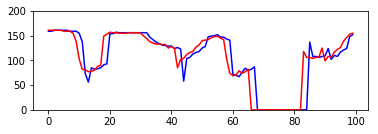

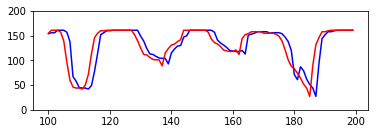

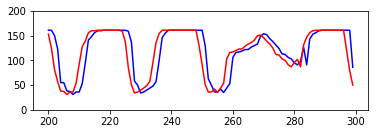

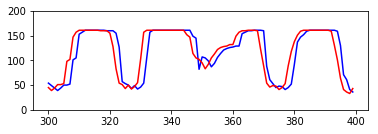

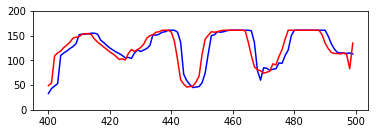

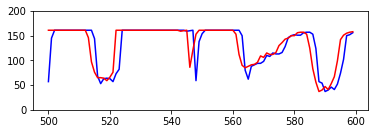

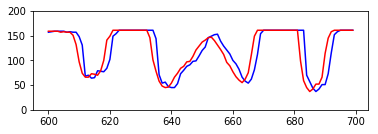

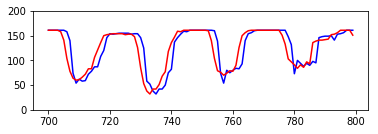

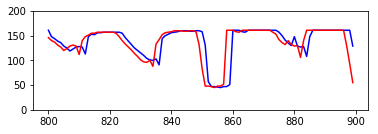

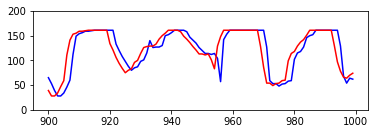

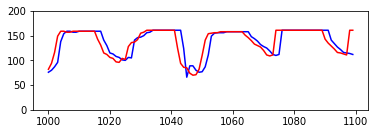

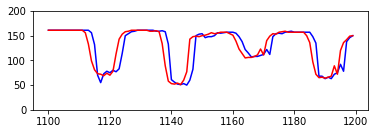

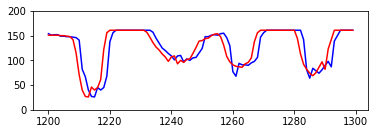

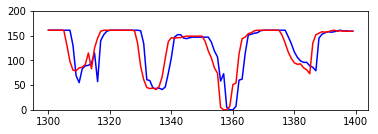

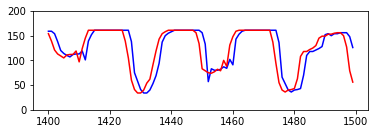

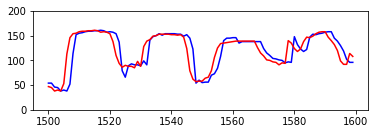

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

viewport_x = 100
segments = int(len(Z) / viewport_x)
for i in range(segments):
    if i == segments:
        x = [(viewport_x*i + j) for j in range(viewport_x) if ((viewport_x*i + j) < len(Z))]
        y1 = Z[(viewport_x*i):]
        y2 = act_set[(viewport_x*i):]        
    else:
        x = [(viewport_x*i + j) for j in range(viewport_x)]
        y1 = Z[(viewport_x*i):(viewport_x*i+viewport_x)]
        y2 = act_set[(viewport_x*i):(viewport_x*i+viewport_x)]
    plt.figure(i)
    plt.subplot(211)
    axes = plt.gca()
    axes.set_ylim([0, 200])
    plt.plot(x, y1, 'b-', x, y2, 'r-')

plt.show()

In [1]:
diff = available_spots[:,0]

def diff_i(diff, order):
    diff_prev = list(diff)
    diff_next = list()
    for i in range(order):
        diff_next = [diff_prev[0]]
        diff_next.extend([(diff_prev[i] - diff_prev[i-1]) for i in range(1, len(diff_prev))])
        diff_prev = list(diff_next)
    return diff_next

pd.DataFrame(diff_next).to_csv('diff_order2.csv')
plt.show()

NameError: name 'available_spots' is not defined